In [114]:
import os
import kagglehub
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image

"""
    Image loading and preprocessing
"""

image_size = 72

dataset_path = kagglehub.dataset_download("subinium/emojiimage-dataset")
description = pd.read_csv(dataset_path + '/full_emoji.csv')
names = description['name'] # to sie przyda jako label zwracany, potem do Flaska

image_data = []
labels = []

dataset_path += '/image'
for dir in os.listdir(dataset_path):
    temp_path = dataset_path + f'/{dir}'
    for image_name in os.listdir(temp_path):
        image = Image.open(temp_path + f'/{image_name}')\
            .convert('RGB')
        
        to_append = np.array(image).T / 255.
        if to_append.shape == (3, 72, 72): # majority of the data
            image_data.append(
                to_append
            )
            labels.append(
                image_name.split('.')[0]
            )

/home/mamusiaarusia/myenv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [116]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256
labels_encoded = pd.get_dummies( np.array(labels, dtype=int) ).to_numpy()
image_data = np.array(image_data)

image_train, image_test, label_train, label_test = train_test_split(image_data, labels_encoded, test_size=0.15)

image_dataset = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.Tensor(image_train),
        torch.Tensor(label_train)
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

image_test = torch.Tensor(image_test).float().cuda()
label_test  = torch.Tensor(label_test).int().cuda()

In [ ]:
class CNN(nn.Module):
    def __init__(self, layers, lr):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = torch.optim.RMSprop(self.parameters(), lr)
        self.loss = nn.CrossEntropyLoss()
        self.to('cuda')

    def forward(self, input):
        return self.layers(input)
    
layers = [
    nn.LazyConv2d(4,  kernel_size=3, stride=2), nn.ReLU(), # 70x70x4
    nn.LazyConv2d(8,  kernel_size=3), nn.ReLU(), # 68x68x8
    nn.LazyConv2d(16, kernel_size=3, stride=2), nn.ReLU(), # 66x66x4
    nn.LazyConv2d(32, kernel_size=3), nn.ReLU(), # 64x64x4
    nn.Flatten(),
    nn.LazyLinear(labels_encoded.shape[1]),
]

model = CNN(layers, 1e-3)

EPOCHS = 1000
loss_history = np.zeros(EPOCHS)

model.train()

for epoch in range(EPOCHS):
    for training_batch, label_batch in image_dataset:
        training_batch = training_batch.cuda()
        label_batch = label_batch.cuda()

        model.optim.zero_grad()
        output = model(training_batch).reshape( *label_batch.shape )
        loss = model.loss(output, label_batch)
        loss.backward()
        model.optim.step()

    print(f'\r{(epoch + 1) / EPOCHS*100 :.1f}%', end='', flush=True)
    loss_history[epoch] = loss.item()

model.eval()

100.0%

CNN(
  (layers): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3364, out_features=1816, bias=True)
  )
  (loss): CrossEntropyLoss()
)

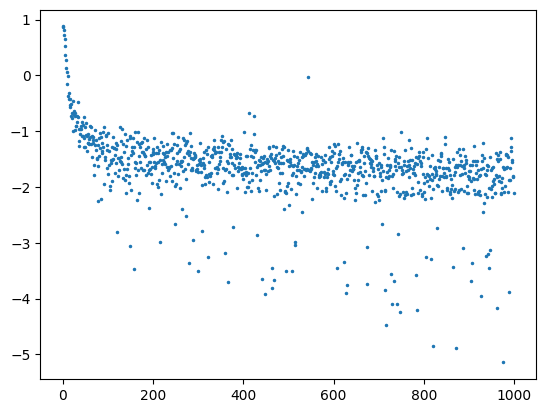

In [106]:
import matplotlib.pyplot as plt

plt.plot(np.log10(loss_history), 'o', markersize=1.5)

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

label_pred = model(image_test).detach().cpu()
accuracy_score( label_test.cpu().argmax(dim=-1, keepdim=True), label_pred.cpu().argmax(dim=-1, keepdim=True) )
# confusion = confusion_matrix(label_test, output_test)

# ConfusionMatrixDisplay(confusion).plot()

0.1912568306010929

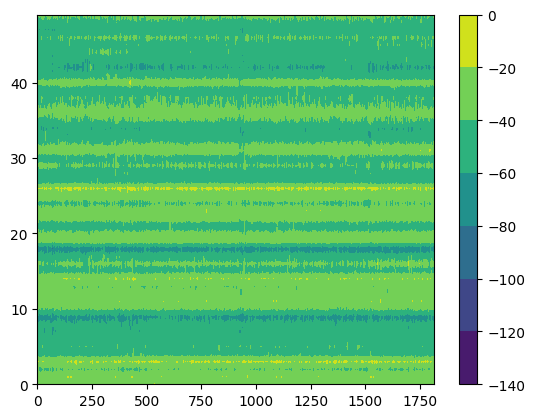

In [105]:
label_pred = np.array(label_pred)

plt.contourf(label_pred[:50])
plt.colorbar()